In [37]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('dark')
warnings.filterwarnings('ignore')

In [2]:
# Load and check dataset
df = pd.read_csv('cc_general.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [3]:
# Rename columns
df.columns = df.columns.str.lower()

In [4]:
# Fill NA
df['credit_limit'].fillna(df['credit_limit'].mean(), inplace=True)
df['minimum_payments'].fillna(df['minimum_payments'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

In [5]:
# Final data
df_cluster = df.iloc[:, 1:]

# Clustering

O agrupamento dos dados será mais bem sucedido se ele atender a essas 2 premissas:

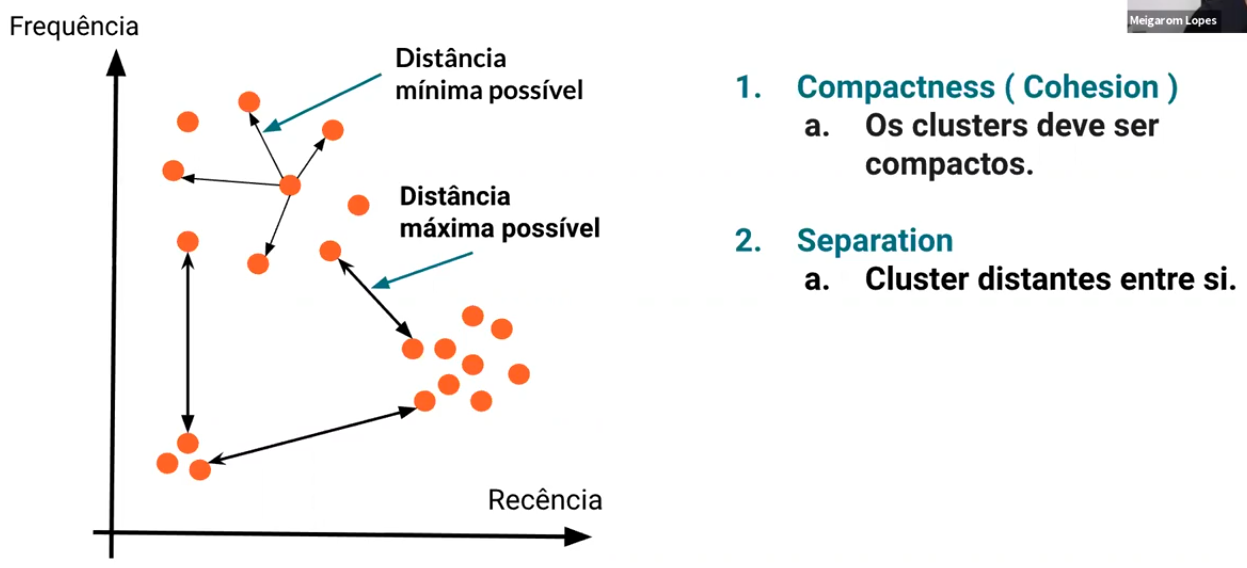

In [21]:
# Plot
def plot_data(x, y, x_label='', y_label='', title=''):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y, marker='o')
    plt.show()

In [7]:
# Parameters
from sklearn.cluster import KMeans
n_clusters = [i for i in range(2, 11, 1)]
seed = 42

## WSS (Within-Cluster Sum of Square)

Observa a distância dos elementos intra-cluster e quanto menor o índice significa que os elementos estão mais coesos.

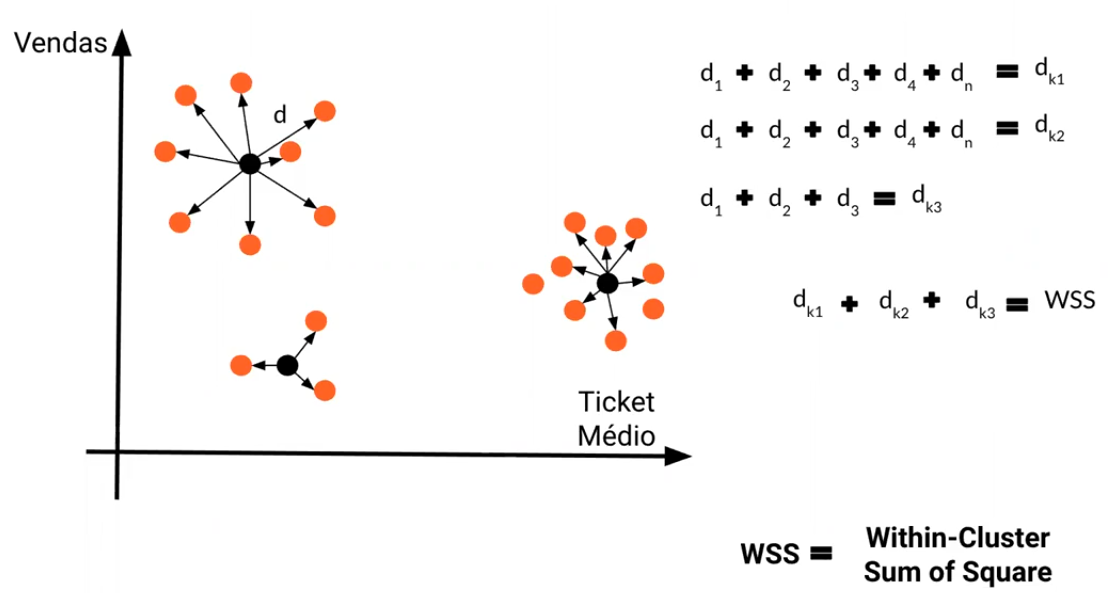

No modelo de KMeans o valor de WSS é obtido por meio do método de *inertia*.

Com o WSS criou-se o **elbow method (método do cotovelo)** e com ele busca-se identificar a quantidade de clusters que melhor representa o conjunto de dados e e olha-se o ponto em que a curva do gráfico se dobra.

Como essa dobra pode não ficar muito bem representada, ou ser bastante subjetiva, é possível utilizar uma fórmula para obtenção do melhor número de clusters:

$$distance(P_0,P_1,(x,y))=\frac{|(y_1-y_0)x-(x_1-x_0)y+x_1y_0-y_1x_0|}{\sqrt{(y_1-y_0)^2+(x_1-x_0)^2)}}$$

O ponto que indica o equilíbrio entre maior homogeneidade dentro do cluster e a maior diferença entre clusters, é o ponto da curva mais distante de uma reta traçada entre os primeiro e último pontos. O segundo gráfico apresenta essa diferença.


Refs:

https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9

https://en.wikipedia.org/wiki/Elbow_method_(clustering)

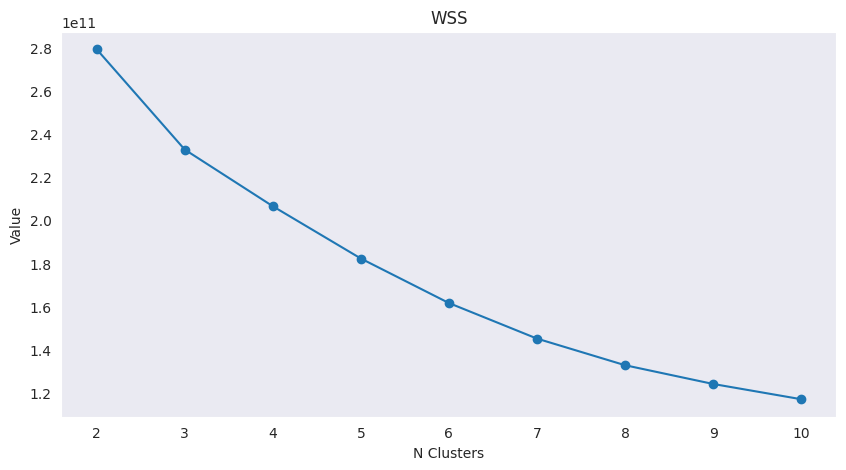

In [25]:
# Get wss values
wss = []
for cl in n_clusters:
    km_elbow = KMeans(n_clusters=cl, n_init=10, random_state=seed)
    km_elbow.fit(df_cluster)
    wss.append(km_elbow.inertia_)

# Get distances values
x1, y1 = 2, wss[0]
x2, y2 = 10, wss[len(wss)-1]
distances = []
for i in range(len(wss)):
    x0 = i+2
    y0 = wss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)

params = {
    'x': n_clusters,
    'y': wss,
    'x_label': 'N Clusters',
    'y_label': 'Value',
    'title': 'WSS' 
}    
    
plot_data(**params)

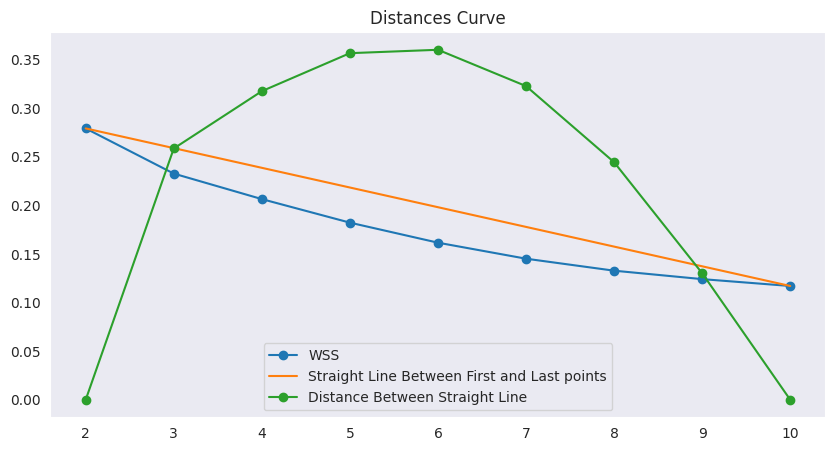

In [26]:
# Plot distances curve
max_div = 10e11
wss_div = [i/max_div for i in wss]
distances_div = [i/5 for i in distances]

plt.figure(figsize=(10, 5))
plt.plot(n_clusters, wss_div, marker='o', label='WSS')

plt.plot(
    [x1, x2], [y1/max_div, y2/max_div], 
    label='Straight Line Between First and Last points')

plt.plot(
    n_clusters, 
    distances_div, 
    marker='o', label='Distance Between Straight Line')

plt.legend()
plt.title('Distances Curve')
plt.show()

## Silhouette Coefficient (Coeficiente da Silhueta)

Observa as distâncias intra e extra cluster. Pode ser um valor entre -1 e 1 e quanto mais próximo de 1 significa cluster mais claros.

Observação:
* Se o valor da silhueta for próximo a 1, a amostra está bem agrupada e já atribuída a um agrupamento muito apropriado.
* Se o valor da silhueta for cerca de 0, a amostra pode ser atribuída a outro cluster mais próximo a ele e a amostra fica igualmente longe de ambos os clusters. Isso significa que indica clusters sobrepostos
* Se o valor da silhueta estiver próximo a -1, a amostra foi classificada incorretamente e foi simplesmente colocada em algum lugar entre os clusters.


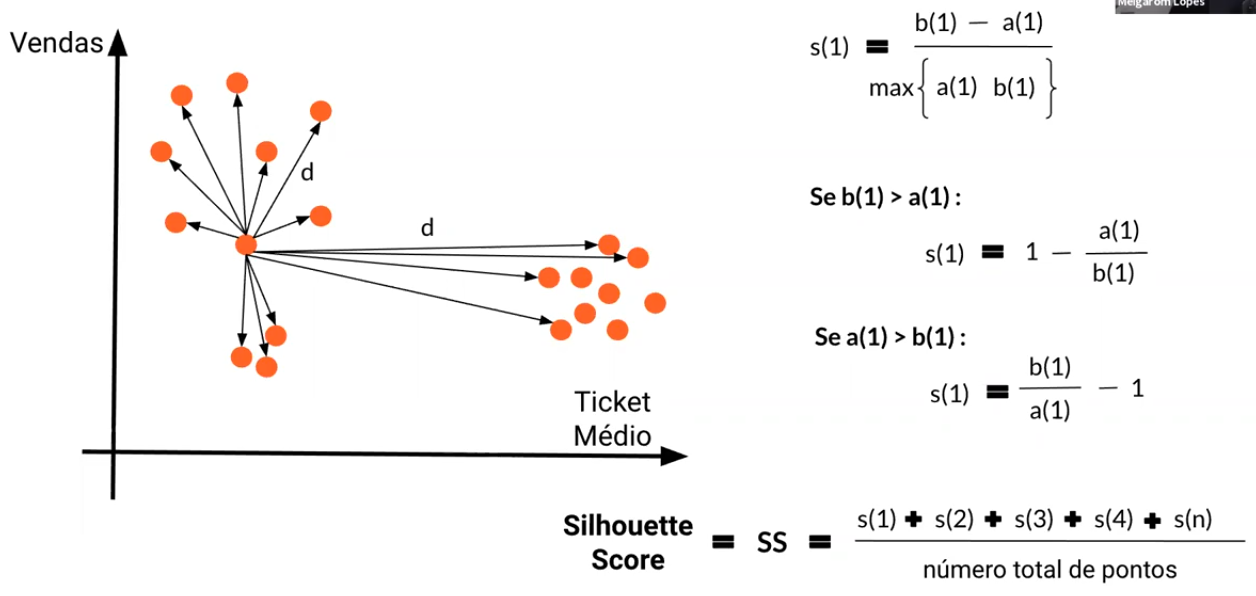

Refs:

https://acervolima.com/silhouette-index-indice-de-validade-de-cluster-conjunto-2/

https://en.wikipedia.org/wiki/Silhouette_(clustering)

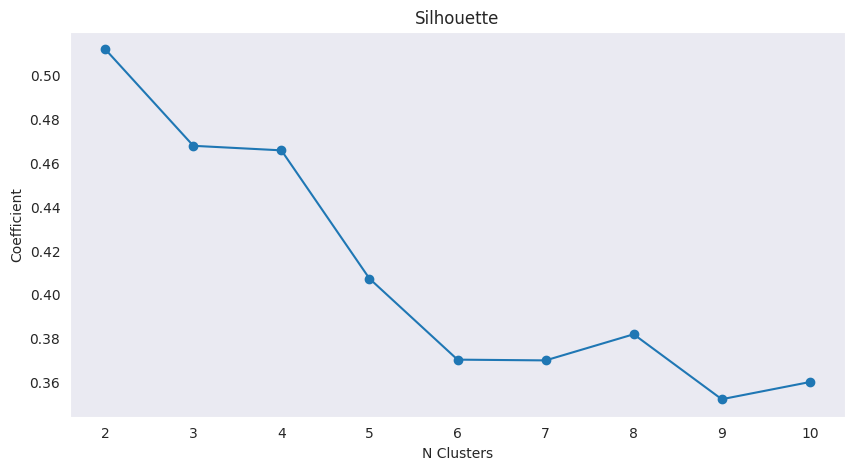

In [28]:
from sklearn.metrics import silhouette_score

sil = []
for cl in n_clusters:
    km_elbow = KMeans(n_clusters=cl, n_init=10, random_state=seed)
    km_elbow.fit(df_cluster)
    sil.append(silhouette_score(df_cluster, km_elbow.labels_))

params = {
    'x': n_clusters,
    'y': sil,
    'x_label': 'N Clusters',
    'y_label': 'Coefficient',
    'title': 'Silhouette' 
}

plot_data(**params)

## Davies-Bouldin Index (DB-Index)
 
É o índice de semelhança média entre cada cluster e o cluster mais próximo.

$S$ menor indica mais coesão no cluster;

$d$ maior significa que estão mais distantes;

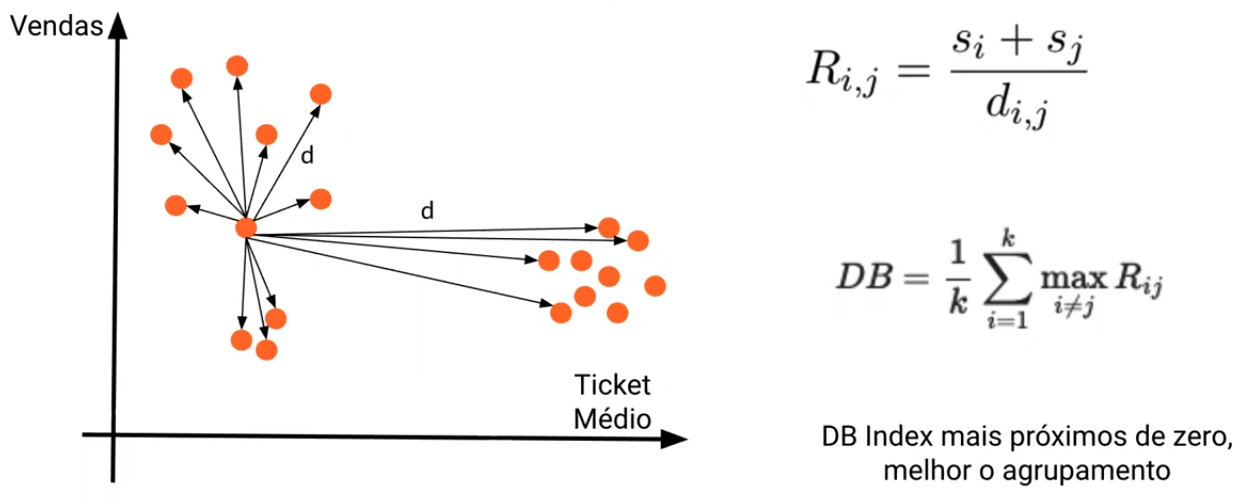

Refs:

https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index

https://cursos.alura.com.br/forum/topico-entendimento-da-explicacao-matematica-de-davies-boudin-176967

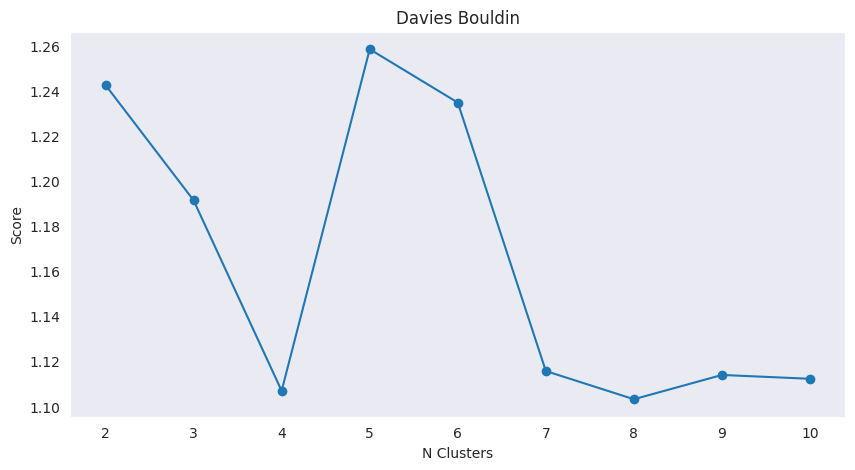

In [29]:
from sklearn.metrics import davies_bouldin_score

db = []
for cl in n_clusters:
    km_elbow = KMeans(n_clusters=cl, n_init=10, random_state=seed)
    km_elbow.fit(df_cluster)
    db.append(davies_bouldin_score(df_cluster, km_elbow.labels_))

params = {
    'x': n_clusters,
    'y': db,
    'x_label': 'N Clusters',
    'y_label': 'Score',
    'title': 'Davies Bouldin' 
}

plot_data(**params)

## Calinski-Harabasz Index

É a razão entre a dispersões intra e extracluster. Uma pontuação maior será melhor.

Refs:

https://acervolima.com/indice-calinski-harabasz-indices-de-validade-de-cluster-conjunto-3/

https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/

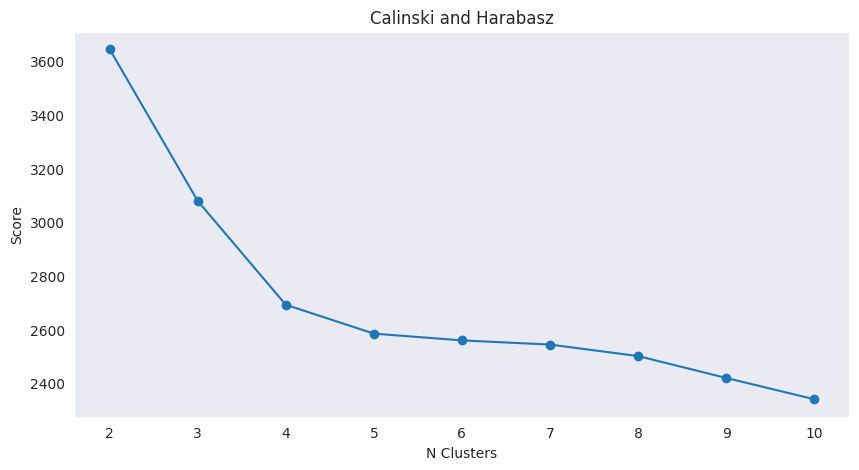

In [30]:
from sklearn.metrics import calinski_harabasz_score

ch = []
for cl in n_clusters:
    km_elbow = KMeans(n_clusters=cl, n_init=10, random_state=seed)
    km_elbow.fit(df_cluster)
    ch.append(calinski_harabasz_score(df_cluster, km_elbow.labels_))

params = {
    'x': n_clusters,
    'y': ch,
    'x_label': 'N Clusters',
    'y_label': 'Score',
    'title': 'Calinski and Harabasz' 
}

plot_data(**params)

## Dunn Index

Identificar conjuntos de clusters que são compactos, com uma pequena variação entre os membros do cluster, e bem separados, onde as médias dos diferentes clusters estão suficientemente distantes, em comparação com o dentro da variância do cluster. Quanto maior o valor do índice Dunn, melhor é o agrupamento.

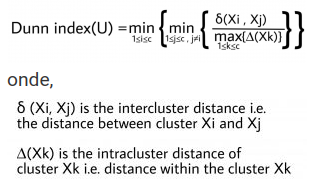

Refs:

https://acervolima.com/indice-de-dunn-e-indice-db-indices-de-validade-de-cluster-conjunto-1/

https://pyshark.com/dunn-index-for-k-means-clustering-evaluation-using-python/#calculate-dunn-index

https://en.wikipedia.org/wiki/Dunn_index

In [ ]:
# Implementar

## Silhouette Coefficient using Yellobrick lib

A linha vermelha é a pontuação média e o objetivo é garantir que cada cluster se destaque acima dela.

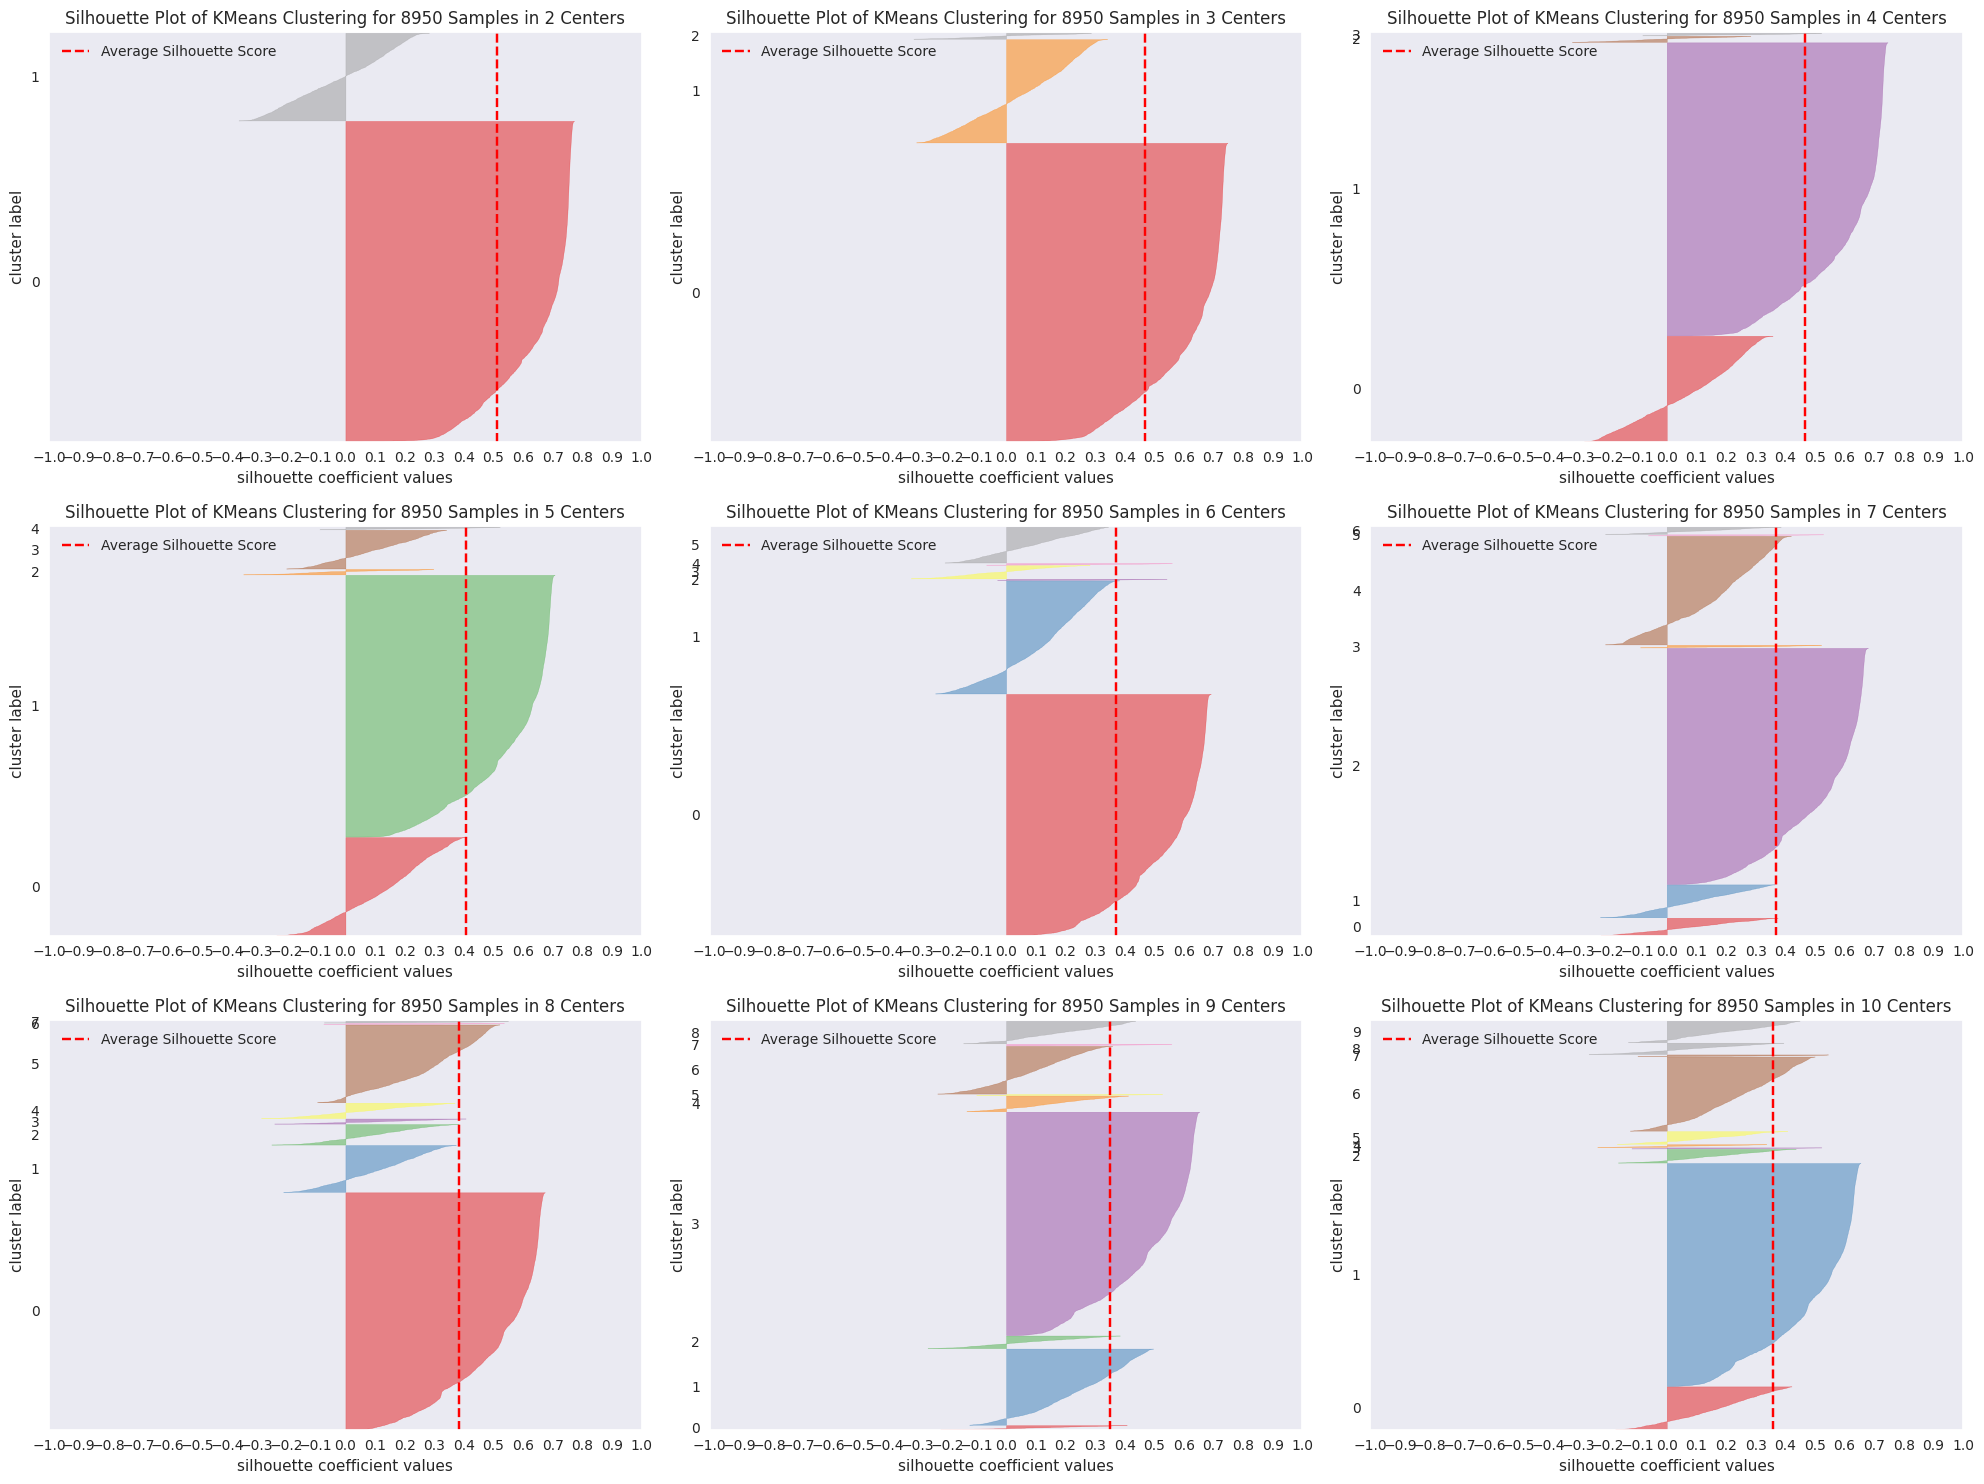

In [53]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

fig, axes = plt.subplots(3, 3, figsize=(20,15))
axes = axes.reshape(9)
for i, k in enumerate(n_clusters):
    ax = axes[i]
    md = KMeans(n_clusters=k, random_state=seed)
    viz = SilhouetteVisualizer(md, ax=ax)
    viz.fit(df_cluster)
    viz.finalize()
    ax.set_xlim(-1, 1)
plt.tight_layout()